In [1]:
%reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

# create the model
m = ConcreteModel()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [2]:
N = 20 # how many points are in the trajectory
hm = 0.5/N #scaling factor
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.

m.g = Param(initialize = 9.81)
m.X0 = Param(initialize = 0.0) # position of fixed base
m.Z0 = Param(initialize = 1.0)
# m.h = Param(initialize = 0.02) # time step

# mass of links
m.m1 = Param(initialize = 0.35)
m.m2 = Param(initialize = 0.15)
m.m3 = Param(initialize = 0.35)
m.m4 = Param(initialize = 0.15)

mbody = m.m1.value+m.m2.value+m.m3.value+m.m4.value
mBW = mbody*m.g.value

# length of links
m.l1 = Param(initialize = 0.12) 
m.l2 = Param(initialize = 0.24) 
m.l3 = Param(initialize = 0.12) 
m.l4 = Param(initialize = 0.24) 
# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

#Inertia
m.In1= Param(initialize = m.m1.value*m.l1.value**2/12) 
m.In2= Param(initialize = m.m2.value*m.l2.value**2/12)
m.In3= Param(initialize = m.m3.value*m.l3.value**2/12)
m.In4= Param(initialize = m.m4.value*m.l4.value**2/12)

#Forces
m.t_max=6.864655 #Nm, corresponding to a 8V input
m.w_max=8.055366 #rad/s, corresponding to a 8V input

#Not exactly sure what this is?
m.distance=0.4

print("Done")

Done


In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m1,m2,m3,m4 = sym.symbols(['m1','m2','m3','m4']) # mass of links
l1,l2,l3,l4 = sym.symbols(['l1','l2','l3','l4']) # length of links
In1,In2,In3,In4 = sym.symbols(['In1','In2','In3','In4']) # moment of intertia of links

# generalized coordinates
x,z,th1,th2,th3,th4 = sym.symbols(['x','z','theta1','theta2','theta3','theta4']) #position
dx,dz,dth1,dth2,dth3,dth4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{1}','\dot{\\theta}_{2}','\dot{\\theta}_{3}','\dot{\\theta}_{4}']) #velocity
ddx,ddz,ddth1,ddth2,ddth3,ddth4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{1}','\ddot{\\theta}_{2}','\ddot{\\theta}_{3}','\ddot{\\theta}_{4}']) #acceleration

q = sym.Matrix([[x],[z],[th1],[th2],[th3],[th4]]) #group into matrices
dq = sym.Matrix([[dx],[dz],[dth1],[dth2],[dth3],[dth4]])
ddq = sym.Matrix([[ddx],[ddz],[ddth1],[ddth2],[ddth3],[ddth4]])

# forces
tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z = sym.symbols(['\\tau_1','\\tau_2','\\tau_3','\\tau_4','G1_x','G1_z','G2_x','G2_z']) 

print('Done')

Done


In [4]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

x1 = x + 0.5*l1*sym.sin(th1)
z1 = z - 0.5*l1*sym.cos(th1)

x2 = x + l1*sym.sin(th1) + 0.5*l2*sym.sin(th1+th2)
z2 = z - l1*sym.cos(th1) - 0.5*l2*sym.cos(th1+th2)

x3 = x + 0.5*l3*sym.sin(th3)
z3 = z - 0.5*l3*sym.cos(th3)

x4 = x + l3*sym.sin(th3) + 0.5*l4*sym.sin(th3+th4)
z4 = z - l3*sym.cos(th3) - 0.5*l4*sym.cos(th3+th4)

foot1x = sym.Matrix([x + l1*sym.sin(th1) + l2*sym.sin(th2)])
foot1z = sym.Matrix([z - l1*sym.cos(th1) - l2*sym.cos(th2)]) 
foot1z = foot1z[0].simplify()
foot1_pos= sym.Matrix([[foot1x],[foot1z]]);

foot2x = sym.Matrix([x + l3*sym.sin(th3) + l4*sym.sin(th4)])
foot2z = sym.Matrix([z - l3*sym.cos(th3) - l4*sym.cos(th4)]) 
foot2z = foot2z[0].simplify()
foot2_pos= sym.Matrix([[foot2x],[foot2z]]);

print('Done')

Done


In [5]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,z1])
v1 = p1.jacobian(q)*dq
[dx1,dz1] = v1

p2 = sym.Matrix([x2,z2])
v2 = p2.jacobian(q)*dq
[dx2,dz2] = v2 

p3 = sym.Matrix([x3,z3])
v3 = p3.jacobian(q)*dq
[dx3,dz3] = v3 

p4 = sym.Matrix([x4,z4])
v4 = p4.jacobian(q)*dq
[dx4,dz4] = v3 

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()

print('Done')

Done


In [6]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M1 = sym.Matrix([[m1,m1]])
M2 = sym.Matrix([[m2,m2]])
M3 = sym.Matrix([[m3,m3]])
M4 = sym.Matrix([[m4,m4]])

I1=sym.Matrix([[In1]])
I2=sym.Matrix([[In2]])
I3=sym.Matrix([[In3]])
I4=sym.Matrix([[In4]])

W1=sym.Matrix([[dth1]])
W2=sym.Matrix([[dth1+dth2]])
W3=sym.Matrix([[dth3]])
W4=sym.Matrix([[dth3+dth4]])

# linear kinetic energy:
Tl = 0.5*M1*sym.matrix_multiply_elementwise(v1,v1) + 0.5*M2*sym.matrix_multiply_elementwise(v2,v2) + 0.5*M3*sym.matrix_multiply_elementwise(v3,v3) + 0.5*M4*sym.matrix_multiply_elementwise(v4,v4)
# angular kinetic energy:
Tw =  0.5*I1*sym.matrix_multiply_elementwise(W1,W1) + 0.5*I2*sym.matrix_multiply_elementwise(W2,W2) + 0.5*I3*sym.matrix_multiply_elementwise(W3,W3) + 0.5*I4*sym.matrix_multiply_elementwise(W4,W4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1] + m4*g*p4[1]
print('Done')

Done


In [7]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #z
Q[2]=tau1              #th1
Q[3]=tau2              #th2
Q[4]=tau3              #th3
Q[5]=tau4              #th4


J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2z]])

EOM=M*ddq+C*dq+G-Q-GRF_1-GRF_2

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()  #--> Helps to make simulation faster for bigger problems

#display(EOMs[0])
print('Done')

Done


In [8]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m1,m2,m3,m4,l1,l2,l3,l4,
            In1,In2,In3,In4,x,z,th1,th2,th3,th4,
            dx,dz,dth1,dth2,dth3,dth4,ddx,ddz,ddth1,ddth2,
            ddth3,ddth4,tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th1 = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th2 = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th3 = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th4 = sym.lambdify(sym_list,EOMs[5],modules = [func_map])

lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])

lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])

print('Done')

Done


In [9]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('leg',1),('leg',2),('leg',3),('leg',4)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_1','theta_2','theta_3','theta_4'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
#collocation points
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

#nodes
m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

#time
m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)

m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [10]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [11]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [12]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Z','THETA1', 'THETA2','THETA3','THETA4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =1.00)
print('Done')

Done


In [13]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 
print('Done')

Done


In [14]:
# CONTACT
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)
def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)
def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

print('Done')

Done


In [15]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF1[n,c,'Z','ps'] - (m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)
def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

def def_a_friction_2(m,n,c):   
    return m.a_friction_2[n,c] == m.mu*m.GRF2[n,c,'Z','ps'] - (m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)
def def_b_friction_2(m,n,c):   
    return m.b_friction_2[n,c] == m.gamma_2[n,c]
m.def_b_friction_2 = Constraint(m.N, m.cN, rule = def_b_friction_2)

print('Done')

Done


In [16]:
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_foot1dx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)
def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF1[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)

# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_foot1dx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)
def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF1[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

#SLIP POS DIR
def def_a_slip_p_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_2[n,c] ==m.gamma_2[n,c]+lamb_foot2dx(*var_list)
m.def_a_slip_p_2 = Constraint(m.N, m.cN, rule = def_a_slip_p_2)
def def_b_slip_p_2(m,n,c):   
    return m.b_slip_p_2[n,c] == m.GRF2[n,c,'X','ps']
m.def_b_slip_p_2 = Constraint(m.N, m.cN, rule = def_b_slip_p_2)

# SLIP NEG DIR
def def_a_slip_n_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_2[n,c] ==m.gamma_2[n,c]-lamb_foot2dx(*var_list)
m.def_a_slip_n_2 = Constraint(m.N, m.cN, rule = def_a_slip_n_2)
def def_b_slip_n_2(m,n,c):   
    return m.b_slip_n_2[n,c] == m.GRF2[n,c,'X','ng']
m.def_b_slip_n_2 = Constraint(m.N, m.cN, rule = def_b_slip_n_2)

print('Done')

Done


In [17]:
#Leg 1
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

#Leg 2
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

def def_friction_2_pr(m,n):
    a_friction_2_pr = m.a_friction_2[n,1] + m.a_friction_2[n,2] + m.a_friction_2[n,3] 
    b_friction_2_pr = m.b_friction_2[n,1] + m.b_friction_2[n,2] + m.b_friction_2[n,3]  
    return a_friction_2_pr*b_friction_2_pr <= m.eps
m.def_friction_2_pr = Constraint(m.N, rule = def_friction_2_pr)

def def_slip_p_2_pr(m,n):
    a_slip_p_2_pr = m.a_slip_p_2[n,1] + m.a_slip_p_2[n,2] + m.a_slip_p_2[n,3] 
    b_slip_p_2_pr = m.b_slip_p_2[n,1] + m.b_slip_p_2[n,2] + m.b_slip_p_2[n,3]  
    return a_slip_p_2_pr*b_slip_p_2_pr <= m.eps
m.def_slip_p_2_pr = Constraint(m.N, rule = def_slip_p_2_pr)

def def_slip_n_2_pr(m,n):
    a_slip_n_2_pr = m.a_slip_n_2[n,1] + m.a_slip_n_2[n,2] + m.a_slip_n_2[n,3] 
    b_slip_n_2_pr = m.b_slip_n_2[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_2[n,3]  
    return a_slip_n_2_pr*b_slip_n_2_pr <= m.eps
m.def_slip_n_2_pr = Constraint(m.N, rule = def_slip_n_2_pr)

print('Done')

Done


In [18]:
m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_1
m.tau_b = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_2
m.tau_c = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_3
m.tau_d = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_4

def def_hip1_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_b[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_b[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1']-m.dq0[n,'theta_2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

def def_hip3_motor_model_p(m,n):
    return  m.tau_c[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_c[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_d[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_d[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3']-m.dq0[n,'theta_4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [19]:
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

S=1.0 #BW/m.mTot    
#Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_th1(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th1(*var_list) == 0
m.EOM_th1 = Constraint(m.N, m.cN, rule = EOM_th1)

def EOM_th2(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th2(*var_list) == 0
m.EOM_th2 = Constraint(m.N, m.cN, rule = EOM_th2)

def EOM_th3(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th3(*var_list) == 0
m.EOM_th3= Constraint(m.N, m.cN, rule = EOM_th3)
                      
def EOM_th4(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th4(*var_list) == 0
m.EOM_th4= Constraint(m.N, m.cN, rule = EOM_th4)

print('Done')

Done


In [20]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth1Bounds(m,n):
    return (-2, m.q0[n,'theta_1'], 2)
m.setth1Bounds = Constraint(m.N, rule=setth1Bounds)
def setth2Bounds(m,n):
    return (-2, m.q0[n,'theta_2'], 2)
m.setth2Bounds = Constraint(m.N, rule=setth2Bounds)
def setth3Bounds(m,n):
    return (-2, m.q0[n,'theta_3'], 2)
m.setth3Bounds = Constraint(m.N, rule=setth3Bounds)
def setth4Bounds(m,n):
    return (-2, m.q0[n,'theta_4'], 2)
m.setth4Bounds = Constraint(m.N, rule=setth4Bounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
def setdth1Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_1'],m.w_max)
m.setdth1Bounds = Constraint(m.N, rule=setdth1Bounds)
def setdth2Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_2'],m.w_max)
m.setdth2Bounds = Constraint(m.N, rule=setdth2Bounds)
def setdth3Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_3'], m.w_max)
m.setdth3Bounds = Constraint(m.N, rule=setdth3Bounds)
def setdth4Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_4'], m.w_max)
m.setdth4Bounds = Constraint(m.N, rule=setdth4Bounds)

print('Done')

Done


In [21]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_1'].value = np.random.uniform(-np.pi/2,np.pi/2)   
        m.q[n,c,'theta_2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
print('Done')

Done


In [22]:
# #DROP TEST
# #--------------------------------------------------------------
# #initial variables
# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True
# m.q[1,1,'z'].value = 0.8
# m.q[1,1,'z'].fixed = True
# m.q[1,1,'theta_1'].value = 0.0
# m.q[1,1,'theta_1'].fixed = True
# m.q[1,1,'theta_2'].value = 0.0
# m.q[1,1,'theta_2'].fixed = True
# m.q[1,1,'theta_3'].value = 0.0
# m.q[1,1,'theta_3'].fixed = True
# m.q[1,1,'theta_4'].value = 0.0
# m.q[1,1,'theta_4'].fixed = True

# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True
# m.dq[1,1,'theta_1'].value = 0.0
# m.dq[1,1,'theta_1'].fixed = True
# m.dq[1,1,'theta_2'].value = 0.0
# m.dq[1,1,'theta_2'].fixed = True
# m.dq[1,1,'theta_3'].value = 0.0
# m.dq[1,1,'theta_3'].fixed = True
# m.dq[1,1,'theta_4'].value = 0.0
# m.dq[1,1,'theta_4'].fixed = True

# for dof in DOFs:   
#     for n in range(1,N+1):
#         m.tau_a[n].value = 0
#         m.tau_a[n].fixed = True
#         m.tau_b[n].value = 0
#         m.tau_b[n].fixed = True
#         m.tau_c[n].value = 0
#         m.tau_c[n].fixed = True
#         m.tau_d[n].value = 0
#         m.tau_d[n].fixed = True

In [23]:
# HOP
#---------------------------------------------------------------

# initial condition
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
# m.q[1,1,'z'].value = 0.8
# m.q[1,1,'z'].fixed = True
# m.q[1,1,'theta_1'].value = 0.5
# m.q[1,1,'theta_1'].fixed = True
# m.q[1,1,'theta_2'].value = -0.5
# m.q[1,1,'theta_2'].fixed = True
# m.q[1,1,'theta_3'].value = -0.5
# m.q[1,1,'theta_3'].fixed = True
# m.q[1,1,'theta_4'].value = 0.5
# m.q[1,1,'theta_4'].fixed = True

m.dq[1,1,'x'].value = 0.0
m.dq[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True
m.dq[1,1,'theta_1'].value = 0.0
m.dq[1,1,'theta_1'].fixed = True
m.dq[1,1,'theta_2'].value = 0.0
m.dq[1,1,'theta_2'].fixed = True
m.dq[1,1,'theta_3'].value = 0.0
m.dq[1,1,'theta_3'].fixed = True
m.dq[1,1,'theta_4'].value = 0.0
m.dq[1,1,'theta_4'].fixed = True
            
# final condition
def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= 0.0   #m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == 0.8
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

In [24]:
##Steady state conditions
#Final position constraints
# def finalX(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] >= 0.0   #m.distance
#     else:
#         return Constraint.Skip
# m.finalX = Constraint(m.N, rule = finalX)

# def finalZ(m,n):
#     if (n==N) :
#         return m.q0[n,'z'] == m.q0[1,'z']
#     else:
#         return Constraint.Skip
# m.finalZ = Constraint(m.N, rule = finalZ)

# def finalth1(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_1'] == m.q0[1,'theta_1']
#     else:
#         return Constraint.Skip
# m.finalth1 = Constraint(m.N, rule = finalth1)

# def finalth2(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_2'] == m.q0[1,'theta_2']
#     else:
#         return Constraint.Skip
# m.finalth2 = Constraint(m.N, rule = finalth2)

# def finalth3(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_3'] == m.q0[1,'theta_3']
#     else:
#         return Constraint.Skip
# m.finalth3 = Constraint(m.N, rule = finalth3)

# def finalth4(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_4'] == m.q0[1,'theta_4']
#     else:
#         return Constraint.Skip
# m.finalth4 = Constraint(m.N, rule = finalth4)

# #Final velocity constraints
# def finaldx(m,n):
#     if (n==N) :
#         return m.dq0[n,'x'] == m.dq0[1,'x']
#     else:
#         return Constraint.Skip
# m.finaldx = Constraint(m.N, rule = finaldx)

# def finaldz(m,n):
#     if (n==N) :
#         return m.dq0[n,'z'] == m.dq0[1,'z']
#     else:
#         return Constraint.Skip
# m.finaldz = Constraint(m.N, rule = finaldz)

# def finaldth1(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_1'] == m.dq0[1,'theta_1']
#     else:
#         return Constraint.Skip
# m.finaldth1 = Constraint(m.N, rule = finaldth1)

# def finaldth2(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_2'] == m.dq0[1,'theta_2']
#     else:
#         return Constraint.Skip
# m.finaldth2 = Constraint(m.N, rule = finaldth2)

# def finaldth3(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_3'] == m.dq0[1,'theta_3']
#     else:
#         return Constraint.Skip
# m.finaldth3 = Constraint(m.N, rule = finaldth3)


# def finaldth4(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_4'] == m.dq0[1,'theta_4']
#     else:
#         return Constraint.Skip
# m.finaldth4 = Constraint(m.N, rule = finaldth4)

print('Done')

Done


In [25]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(((m.tau_a[n]**2+m.tau_b[n]**2+m.tau_c[n]**2+m.tau_d[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13216
Number of nonzeros in inequality constraint Jacobian.:     1581
Number of nonzeros in Lagrangian Hessian.............:     5020

Total number of variables............................:     2933
                     variables with only lower bounds:     1440
                variables with lower and upper bounds:      100
       

   1  1.4563167e+01 1.86e-03 6.14e-01  -1.0 1.66e-01   0.0 9.90e-01 1.00e+00f  1
   2  9.0542611e+00 1.35e-02 1.55e-01  -1.0 4.24e-01  -0.5 1.00e+00 1.00e+00f  1
   3  4.3388230e+00 1.91e-02 5.22e+00  -2.5 7.76e-01  -1.0 6.97e-01 1.00e+00f  1
   4  1.5933820e+00 6.28e-03 7.06e-01  -2.5 1.54e+00  -1.4 8.49e-01 1.00e+00f  1
   5  3.1955093e-01 7.78e-03 2.11e-01  -2.5 2.55e+00  -1.9 1.00e+00 1.00e+00f  1
   6  2.9803526e-01 1.20e-02 2.02e-01  -2.5 2.56e+01  -2.4 7.09e-02 4.00e-02h  2
   7  2.1830102e-01 6.12e-04 5.55e-02  -2.5 6.07e-01  -2.0 1.00e+00 1.00e+00h  1
   8  1.3301610e-01 1.04e-03 9.97e-03  -2.5 8.04e-01  -2.4 1.00e+00 1.00e+00h  1
   9  6.6334960e-02 2.16e-03 5.61e-02  -3.8 9.32e-01  -2.9 9.06e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.6356551e-02 7.03e-05 7.80e-04  -3.8 2.40e-01  -2.5 1.00e+00 1.00e+00h  1
  11  4.3414685e-02 8.56e-04 5.58e-04  -3.8 5.15e-01  -3.0 1.00e+00 1.00e+00h  1
  12  2.4160964e-02 4.84e-02

   1  9.2753609e-01 7.70e+02 5.73e+00  -1.0 8.67e+02  -4.0 3.44e-02 5.92e-02h  1
   2  3.3065638e+00 7.19e+02 1.25e+01  -1.0 1.70e+03  -4.5 1.05e-01 6.67e-02h  1
   3  3.6445822e+00 7.11e+02 8.25e+01  -1.0 3.00e+03  -5.0 9.55e-02 1.05e-02h  1
   4  4.1437578e+00 6.96e+02 9.15e+01  -1.0 4.97e+03  -5.4 3.28e-02 2.13e-02h  1
   5  4.3844660e+00 6.86e+02 1.09e+02  -1.0 1.51e+04  -5.9 3.18e-02 1.48e-02h  1
   6  4.5559720e+00 6.81e+02 2.22e+02  -1.0 5.29e+03  -5.5 2.82e-02 7.74e-03h  1
   7  4.7585748e+00 6.70e+02 1.82e+02  -1.0 1.37e+04  -6.0 1.25e-02 1.58e-02h  1
   8  5.0533725e+00 6.60e+02 2.98e+02  -1.0 5.45e+03  -5.5 2.62e-02 1.56e-02h  1
   9  5.1609654e+00 6.55e+02 2.80e+02  -1.0 2.31e+04  -6.0 5.80e-03 7.22e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.5489348e+00 6.45e+02 2.18e+02  -1.0 2.12e+05  -6.5 1.64e-03 1.52e-02h  1
  11  5.5584404e+00 6.44e+02 3.57e+02  -1.0 5.07e+04  -6.1 2.65e-02 4.87e-04h  1
  12  5.5731380e+00 6.39e+02

  25  2.0520682e-01 3.55e+01 2.62e+03  -1.0 1.88e+03  -5.1 1.44e-01 1.86e-01h  1
  26  1.9090658e-01 5.95e+00 1.78e+03  -1.0 3.07e+03  -5.6 4.47e-01 5.73e-01h  1
  27  1.1960141e-01 4.20e+00 1.47e+03  -1.0 1.09e+03  -6.1 2.07e-01 2.65e-01h  1
  28  1.0311849e-01 3.29e+00 9.54e+02  -1.0 2.20e+02  -5.7 3.56e-01 2.21e-01h  1
  29  1.0662553e-01 1.60e+00 4.09e+02  -1.0 5.29e+02  -6.1 6.62e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  9.9190298e-02 8.49e-01 1.73e+02  -1.0 5.23e+02  -6.6 5.41e-01 1.00e+00f  1
  31  1.2299341e-01 3.66e-01 8.97e+01  -1.0 3.47e+02  -7.1 6.96e-01 1.00e+00h  1
  32  1.2829883e-01 2.40e+00 8.75e+01  -1.0 2.79e+03  -6.7 1.87e-01 5.14e-02h  3
  33  1.3427337e-01 1.39e+00 3.24e+00  -1.0 1.32e+02  -7.1 1.00e+00 1.00e+00h  1
  34  1.1620314e-01 8.33e-02 4.06e+00  -1.0 1.23e+01  -4.0 9.26e-01 1.00e+00h  1
  35  1.0101051e-01 1.98e-02 1.67e-01  -1.0 8.63e+00  -4.5 1.00e+00 1.00e+00h  1
  36  3.5948028e-02 5.00e-02

  43  3.5760850e+00 1.75e+00 3.05e+04  -1.0 2.18e+02  -1.3 3.09e-02 1.78e-02h  1
  44  4.4254723e+00 1.74e+00 4.46e+04  -1.0 8.79e+03  -1.7 2.61e-03 3.76e-03h  1
  45  4.6086182e+00 1.70e+00 4.52e+04  -1.0 3.26e+02  -1.3 2.23e-02 2.14e-02h  1
  46  4.6167392e+00 1.70e+00 1.03e+05  -1.0 2.41e+02  -0.9 1.39e-02 1.79e-03h  1
  47  4.6304264e+00 1.69e+00 9.21e+04  -1.0 8.82e+02  -1.4 4.93e-05 6.83e-03h  1
  48  4.6319774e+00 1.68e+00 1.58e+05  -1.0 3.54e+02  -0.9 1.20e-02 1.33e-03h  1
  49  4.7178919e+00 1.67e+00 1.60e+05  -1.0 3.15e+02  -1.4 1.16e-02 1.02e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  4.7226203e+00 1.67e+00 4.44e+05  -1.0 2.30e+02  -1.0 4.21e-02 1.12e-03h  1
  51  6.4602976e+00 1.52e+00 3.92e+05  -1.0 3.23e+02  -1.5 8.11e-02 8.56e-02h  1
  52  6.8861895e+00 1.50e+00 3.55e+05  -1.0 3.42e+02  -1.0 1.04e-02 1.38e-02h  1
  53  7.2054690e+00 1.50e+00 3.56e+05  -1.0 2.16e+03  -1.5 1.32e-04 3.63e-04h  2
  54  7.5178130e+00 1.49e+00

 136  2.1450508e+01 8.79e-01 2.46e+07  -1.0 1.18e+03  -0.5 2.53e-03 4.36e-03h  1
 137  2.1418291e+01 8.78e-01 4.20e+07  -1.0 1.26e+03  -0.1 1.60e-02 1.07e-03h  1
 138  2.0553552e+01 8.70e-01 4.44e+07  -1.0 1.22e+03  -0.5 1.64e-02 9.92e-03h  1
 139  2.0194770e+01 8.64e-01 3.67e+07  -1.0 1.29e+03  -0.1 1.93e-04 6.87e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.8968713e+01 8.57e-01 3.59e+07  -1.0 1.41e+03  -0.6 6.20e-03 7.63e-03h  1
 141  1.8587924e+01 8.53e-01 6.60e+07  -1.0 1.29e+03  -0.2 3.31e-02 5.07e-03h  1
 142  1.7003116e+01 8.46e-01 6.55e+07  -1.0 2.55e+03  -0.6 8.79e-03 8.50e-03h  1
 143  1.6847044e+01 8.42e-01 8.01e+07  -1.0 1.25e+03  -0.2 2.08e-02 4.71e-03h  1
 144  1.6739533e+01 8.41e-01 7.76e+07  -1.0 1.59e+04  -0.7 1.00e-03 2.35e-04h  1
 145  1.6313538e+01 8.33e-01 7.76e+07  -1.0 1.21e+03  -0.3 1.05e-02 9.61e-03h  1
 146  1.6080857e+01 8.29e-01 6.59e+07  -1.0 1.28e+03   0.2 4.18e-05 5.24e-03h  1
 147  1.5068441e+01 8.23e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  3.8299752e+00 5.56e-01 1.30e+04  -1.0 2.95e+02  -1.5 1.29e-03 1.03e-04f  1
 231  3.8296094e+00 5.56e-01 1.39e+04  -1.0 2.57e+02  -2.0 4.72e-04 3.22e-04f  1
 232  3.8179781e+00 5.51e-01 3.41e+03  -1.0 3.22e+02  -2.5 3.44e-03 8.35e-03f  1
 233  3.8055086e+00 5.47e-01 9.17e+03  -1.0 3.84e+02  -2.9 1.48e-02 6.63e-03f  1
 234  3.7266812e+00 4.95e-01 2.09e+04  -1.0 4.59e+02  -3.4 7.36e-02 9.51e-02f  1
 235  3.7220172e+00 4.94e-01 1.98e+04  -1.0 5.41e+02  -3.9 1.10e-01 1.54e-03f  1
 236  3.4532475e+00 4.75e-01 5.45e+04  -1.0 2.49e+03  -4.4 6.63e-02 3.79e-02f  1
 237  3.4500919e+00 4.75e-01 1.51e+05  -1.0 1.96e+03  -4.8 5.07e-02 6.30e-04h  1
 238  3.1268612e+00 4.44e-01 5.36e+04  -1.0 1.34e+03  -5.3 2.77e-02 6.35e-02h  1
 239  3.1912170e+00 4.40e-01 1.60e+05  -1.0 1.64e+03  -4.0 3.42e-02 8.74e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  3.3099582e+00 4.08e-01

 323  1.4614181e+01 2.77e-01 2.20e+08  -1.0 2.63e+03  -2.0 7.84e-03 1.05e-03h  4
 324  1.4953419e+01 2.77e-01 2.58e+08  -1.0 5.49e+03  -2.5 5.41e-03 4.21e-04h  5
 325  1.5413352e+01 2.76e-01 4.27e+08  -1.0 3.32e+03  -2.1 1.53e-02 9.58e-04h  4
 326  1.5477910e+01 2.76e-01 4.97e+08  -1.0 1.09e+04  -2.6 6.97e-03 4.14e-05h  7
 327  1.5977760e+01 2.76e-01 6.60e+08  -1.0 4.52e+03  -2.1 9.54e-03 6.59e-04h  5
 328  1.6037782e+01 2.76e-01 6.85e+08  -1.0 1.40e+04  -2.6 2.18e-03 3.04e-05h  7
 329  1.6530086e+01 2.76e-01 8.01e+08  -1.0 5.65e+03  -2.2 5.86e-03 5.05e-04h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  2.5775288e+01 5.72e-01 6.53e+08  -1.0 3.67e+03  -1.8 7.75e-03 1.17e-02w  1
 331  2.5624327e+01 5.74e-01 7.48e+08  -1.0 5.65e+03  -0.4 3.82e-03 8.81e-04w  1
 332  2.5590958e+01 5.73e-01 1.26e+09  -1.0 1.57e+03  -0.0 6.15e-03 9.61e-04w  1
 333  1.7012733e+01 2.75e-01 1.05e+09  -1.0 1.47e+04  -0.5 7.75e-03 7.32e-04h  4
 334  1.7398701e+01 2.75e-01

 424  5.9286145e+01 4.39e-01 4.27e+05  -1.0 1.16e+03 -17.6 2.24e-01 5.89e-03f  1
 425  5.9917615e+01 4.34e-01 1.02e+06  -1.0 3.84e+03 -18.0 1.63e-01 9.99e-03f  1
 426  6.1947354e+01 4.27e-01 1.37e+06  -1.0 5.21e+03 -18.5 6.76e-02 1.62e-02h  3
 427  6.4247632e+01 4.19e-01 1.57e+06  -1.0 5.07e+03 -19.0 5.91e-02 1.89e-02h  3
 428  6.6520805e+01 4.10e-01 1.81e+06  -1.0 4.73e+03 -19.5 8.65e-02 2.01e-02h  3
 429  6.9140989e+01 3.99e-01 1.83e+06  -1.0 4.37e+03 -20.0 5.35e-02 2.52e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  7.2234199e+01 3.86e-01 1.92e+06  -1.0 4.11e+03 -20.0 1.43e-01 3.19e-02h  3
 431  7.3350918e+01 3.96e-01 2.09e+06  -1.0 4.08e+03 -20.0 1.28e-01 1.26e-02h  5
 432  7.4759591e+01 4.37e-01 2.29e+06  -1.0 4.28e+03 -20.0 1.64e-01 1.62e-02h  5
 433  7.5933616e+01 4.75e-01 2.44e+06  -1.0 4.50e+03 -20.0 1.39e-01 1.36e-02h  5
 434  7.7306815e+01 5.39e-01 2.61e+06  -1.0 4.67e+03 -20.0 2.06e-01 1.59e-02h  5
 435  7.9127720e+01 6.76e-01

 519  2.1573697e+02 2.47e-01 2.48e+09  -1.0 3.63e+02  -1.1 8.18e-04 7.74e-02F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  2.1549764e+02 2.29e-01 2.31e+09  -1.0 1.85e+02  -0.6 2.62e-02 7.33e-02h  1
 521  2.1543584e+02 2.11e-01 1.78e+09  -1.0 1.70e+02  -0.2 1.33e-02 8.18e-02h  1
 522  2.1542586e+02 2.08e-01 3.87e+09  -1.0 1.46e+02   0.2 1.43e-01 1.49e-02h  1
 523  2.1489371e+02 1.88e-01 3.50e+09  -1.0 1.28e+02  -0.3 1.75e-02 1.03e-01h  1
 524  2.1488981e+02 1.88e-01 3.90e+09  -1.0 1.14e+02   0.2 5.16e-02 1.37e-03h  1
 525  2.1490603e+02 1.87e-01 3.97e+09  -1.0 1.60e+02  -0.3 1.55e-01 1.60e-03h  1
 526  2.1578743e+02 1.74e-01 4.01e+09  -1.0 2.74e+02  -0.8 1.08e-03 7.24e-02h  1
 527  2.1586874e+02 1.73e-01 3.52e+09  -1.0 1.44e+02  -0.4 4.72e-01 8.55e-03h  1
 528  2.1997657e+02 1.17e-01 3.75e+09  -1.0 1.47e+02  -0.8 1.01e-02 3.88e-01h  1
 529  2.2038043e+02 1.11e-01 3.47e+09  -1.0 2.12e+02  -1.3 6.59e-02 4.88e-02h  1
iter    objective    inf_pr 

 611  7.1238859e+01 2.92e-01 1.05e+04  -2.5 1.19e+03  -5.2 9.10e-02 1.34e-01f  1
 612  7.0048897e+01 2.68e-01 8.48e+03  -2.5 3.61e+02  -4.8 1.16e-01 1.55e-01f  1
 613  6.9635166e+01 2.59e-01 1.03e+04  -2.5 9.81e+02  -5.3 8.19e-02 3.77e-02f  1
 614  6.9267580e+01 2.60e-01 1.38e+04  -2.5 1.61e+04  -5.8 1.17e-02 3.03e-03f  1
 615  6.7942099e+01 2.41e-01 2.76e+04  -2.5 1.04e+03  -5.3 4.17e-01 1.30e-01f  1
 616  6.6929715e+01 1.82e-01 2.19e+04  -2.5 3.53e+02  -4.9 3.53e-01 2.57e-01f  1
 617  6.5470439e+01 1.90e-01 1.72e+04  -2.5 1.37e+03  -5.4 3.51e-02 1.20e-01f  1
 618  6.4384654e+01 1.83e-01 1.17e+04  -2.5 3.89e+02  -5.0 9.34e-01 2.49e-01f  1
 619  6.2989081e+01 2.40e-01 1.03e+04  -2.5 1.63e+03  -5.4 7.52e-02 9.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620  6.2760079e+01 2.27e-01 9.63e+03  -2.5 2.93e+02  -5.0 2.94e-01 6.24e-02h  1
 621  6.2582523e+01 1.82e-01 7.66e+03  -2.5 4.34e+01  -4.6 9.56e-01 2.02e-01h  1
 622  6.2133965e+01 1.43e-01

 707  4.2248304e+01 3.14e-02 2.18e+02  -3.8 9.90e+01  -5.0 8.58e-02 2.49e-01h  1
 708  4.2191019e+01 3.22e-02 2.19e+02  -3.8 7.04e+02  -5.4 1.74e-02 1.97e-02h  1
 709  4.2139952e+01 3.04e-02 1.59e+02  -3.8 1.11e+02  -5.0 1.34e-01 7.19e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710  4.2017105e+01 3.97e-02 2.06e+02  -3.8 6.58e+02  -5.5 2.25e-02 4.64e-02f  1
 711  4.1868410e+01 3.72e-02 2.46e+02  -3.8 1.19e+02  -5.1 8.27e-02 1.99e-01h  1
 712  4.1810714e+01 3.92e-02 2.54e+02  -3.8 4.58e+03  -5.6 2.52e-03 3.37e-03f  1
 713  4.1711948e+01 2.79e-02 1.52e+02  -3.8 1.99e+01  -4.2 3.74e-01 3.17e-01h  1
 714  4.1658808e+01 3.61e-02 1.61e+02  -3.8 7.91e+02  -4.7 5.03e-03 1.22e-02h  1
 715  4.1616446e+01 3.26e-02 1.02e+02  -3.8 2.31e+01  -4.3 2.44e-01 1.11e-01f  1
 716  4.1596831e+01 3.25e-02 9.68e+01  -3.8 6.71e+02  -4.8 1.24e-02 3.90e-03h  1
 717  4.1502423e+01 2.53e-02 8.38e+01  -3.8 3.56e+01  -4.3 1.81e-01 2.41e-01h  1
 718  4.1456491e+01 2.38e-02

 802  3.6853266e+01 9.90e-03 5.07e-01  -5.7 1.35e+01  -5.1 5.20e-01 4.17e-01f  1
 803  3.6848567e+01 1.36e-03 8.09e-04  -5.7 5.30e+00  -4.7 1.00e+00 1.00e+00f  1
 804  3.6843125e+01 2.75e-03 2.58e-01  -5.7 2.23e+01  -5.2 2.87e-01 3.74e-01h  1
 805  3.6842693e+01 2.58e-03 6.68e-02  -5.7 7.97e+00  -4.8 2.44e-01 6.39e-02h  1
 806  3.6841670e+01 2.48e-03 4.93e-01  -5.7 3.71e+01  -5.2 1.22e-01 4.17e-02f  1
 807  3.6841038e+01 2.26e-03 5.11e-01  -5.7 9.29e+00  -4.8 1.62e-01 8.98e-02f  1
 808  3.6827080e+01 3.24e-02 1.57e+00  -5.7 4.77e+01  -5.3 1.92e-01 4.84e-01f  1
 809  3.6824527e+01 2.80e-02 1.17e+00  -5.7 1.57e+01  -4.9 1.71e-01 1.37e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810  3.6818877e+01 1.95e-02 2.10e+00  -5.7 1.95e+01  -5.3 1.00e+00 3.11e-01f  1
 811  3.6805909e+01 3.07e-02 1.19e+00  -5.7 7.55e+01  -5.8 1.63e-01 2.19e-01h  1
 812  3.6788883e+01 3.55e-02 2.27e-01  -5.7 2.37e+01  -5.4 8.03e-01 7.63e-01h  1
 813  3.6784734e+01 3.50e-02

 897  3.5707500e+01 4.49e-02 6.99e+01  -5.7 7.90e+01  -5.3 2.24e-02 1.22e-02h  1
 898  3.5696840e+01 4.02e-02 3.93e+01  -5.7 3.08e+01  -4.9 2.98e-01 1.06e-01f  1
 899  3.5683712e+01 3.98e-02 4.57e+01  -5.7 3.33e+02  -5.4 1.72e-03 1.82e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  3.5673239e+01 3.04e-02 3.69e+01  -5.7 9.17e+00  -4.0 2.11e-01 2.36e-01f  1
 901  3.5667303e+01 2.44e-02 1.96e+01  -5.7 3.84e+00  -3.6 3.50e-01 1.98e-01f  1
 902  3.5653902e+01 1.67e-02 2.59e+01  -5.7 1.52e+01  -4.1 8.66e-02 3.18e-01f  1
 903  3.5649684e+01 1.42e-02 2.80e+01  -5.7 6.55e+00  -3.7 1.72e-02 1.51e-01f  1
 904  3.5646346e+01 1.42e-02 2.44e+01  -5.7 3.58e+03  -4.1 9.38e-04 5.22e-04h  1
 905  3.5641899e+01 1.26e-02 2.32e+01  -5.7 1.17e+01  -3.7 8.65e-02 1.12e-01f  1
 906  3.5639581e+01 1.12e-02 1.59e+01  -5.7 3.37e+00  -3.3 2.00e-01 1.12e-01f  1
 907  3.5637842e+01 1.08e-02 1.09e+01  -5.7 1.74e+01  -3.8 1.06e-01 3.18e-02h  1
 908  3.5636722e+01 1.03e-02

MovieWriter PillowWriter unavailable; using Pillow instead.


ok
optimal
{Member of ddq} : Size=360, Index=ddq_index
    Key         : Lower : Value              : Upper : Fixed : Stale : Domain
    (1, 1, 'z') :  None : 17.167176730927668 :  None : False : False :  Reals
{Member of ddq} : Size=360, Index=ddq_index
    Key         : Lower : Value               : Upper : Fixed : Stale : Domain
    (1, 1, 'x') :  None : -20.086389643912725 :  None : False : False :  Reals


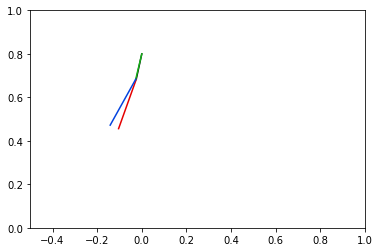

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

print(results.solver.status) 
print(results.solver.termination_condition) 

m.ddq[1,1,'z'].pprint()
m.ddq[1,1,'x'].pprint()

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0,1])
    
    #plot link 1
    link1_top_x = m.q0[i,'x'].value 
    link1_top_z = m.q0[i,'z'].value 
    link1_bottom_x = m.q0[i,'x'].value  + m.l1*np.sin(m.q0[i,'theta_1'].value)
    link1_bottom_z = m.q0[i,'z'].value  - m.l1*np.cos(m.q0[i,'theta_1'].value)  
    ax.plot([link1_top_x,link1_bottom_x],[link1_top_z,link1_bottom_z],color='xkcd:black')
    
    #plot link 2  
    link2_bottom_x = link1_bottom_x + m.l2*np.sin(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    link2_bottom_z = link1_bottom_z - m.l2*np.cos(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    ax.plot([link1_bottom_x,link2_bottom_x],[link1_bottom_z,link2_bottom_z],color='xkcd:red')
    
    #plot link 3
    link3_top_x = m.q0[i,'x'].value  
    link3_top_z = m.q0[i,'z'].value 
    link3_bottom_x = m.q0[i,'x'].value  + m.l3*sin(m.q0[i,'theta_3'].value)
    link3_bottom_z = m.q0[i,'z'].value  - m.l3*cos(m.q0[i,'theta_3'].value)  
    ax.plot([link3_top_x,link3_bottom_x],[link3_top_z,link3_bottom_z],color='xkcd:green')
    
    #plot link 4  
    link4_bottom_x = link3_bottom_x + m.l4*sin(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    link4_bottom_z = link3_bottom_z - m.l4*cos(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    ax.plot([link3_bottom_x,link4_bottom_x],[link3_bottom_z,link4_bottom_z],color='xkcd:blue')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

animate.save('gifs/jump_test_3.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())